In [141]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from altair import Chart, X, Y, Scale
dirs = ['./output/2017-10-12/']
# os.listdir('output/2017-09-12')

In [142]:
# ! scp -i "$KEY_FILE" -r ec2-user@ec2-54-245-174-232.us-west-2.compute.amazonaws.com:~/WideResNet-pytorch/output/2017-10-10 output/

In [144]:
dfs = []
for dir in dirs:
    for filename in os.listdir(dir):
        if 'DS_Store' in filename:
            continue
        print(filename)
        dfs += [pd.read_csv(dir + filename)]
df = pd.concat(dfs)
df = df[df.num_workers == 8]
df.head()

1_42_58.csv
8_42_58.csv


,Unnamed: 0,augment,batch_size,dataset,decode_time,droprate,encode_time,epochs,grad_compute_time,iteration,...,print_freq,resume,seed,start_epoch,step_time,tensorboard,total_step_time,use_cuda,weight_decay,widen_factor
0,0,True,512,cifar10,0.004214,0,0.020186,200,0.953666,1,...,10,NaN,42,0,0.017474,False,0.051164,True,0.0005,1
1,1,True,512,cifar10,0.003744,0,0.014432,200,0.129104,2,...,10,NaN,42,0,0.007886,False,0.054096,True,0.0005,1
2,2,True,512,cifar10,0.004836,0,0.017909,200,0.092588,3,...,10,NaN,42,0,0.010484,False,0.069082,True,0.0005,1
3,3,True,512,cifar10,0.003771,0,0.014533,200,0.094802,4,...,10,NaN,42,0,0.008036,False,0.049557,True,0.0005,1
4,4,True,512,cifar10,0.003840,0,0.015769,200,0.093546,5,...,10,NaN,42,0,0.007939,False,0.055815,True,0.0005,1


In [145]:
df.layers.unique()
# df.batch_size.unique()
# df['encode']

array([58])

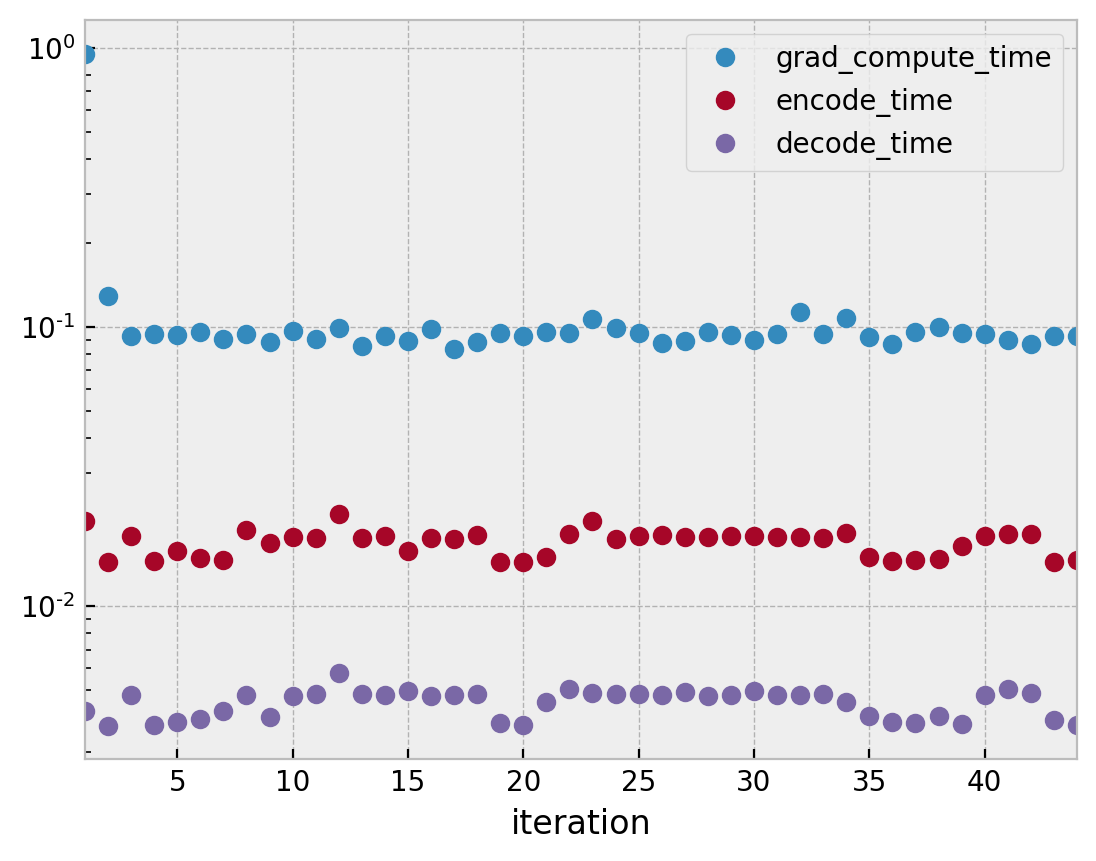

In [146]:
df.plot(x='iteration', y=['grad_compute_time', 'encode_time', 'decode_time'],
        style='o', logy=True)

In [147]:
show = pd.DataFrame({'grad_compute': [df.grad_compute_time.median()],
                             'encode':[df.encode_time.median()],
                             'decode':[df.decode_time.median()]})
show.head()

,decode,encode,grad_compute
0,0.004814,0.017588,0.094246


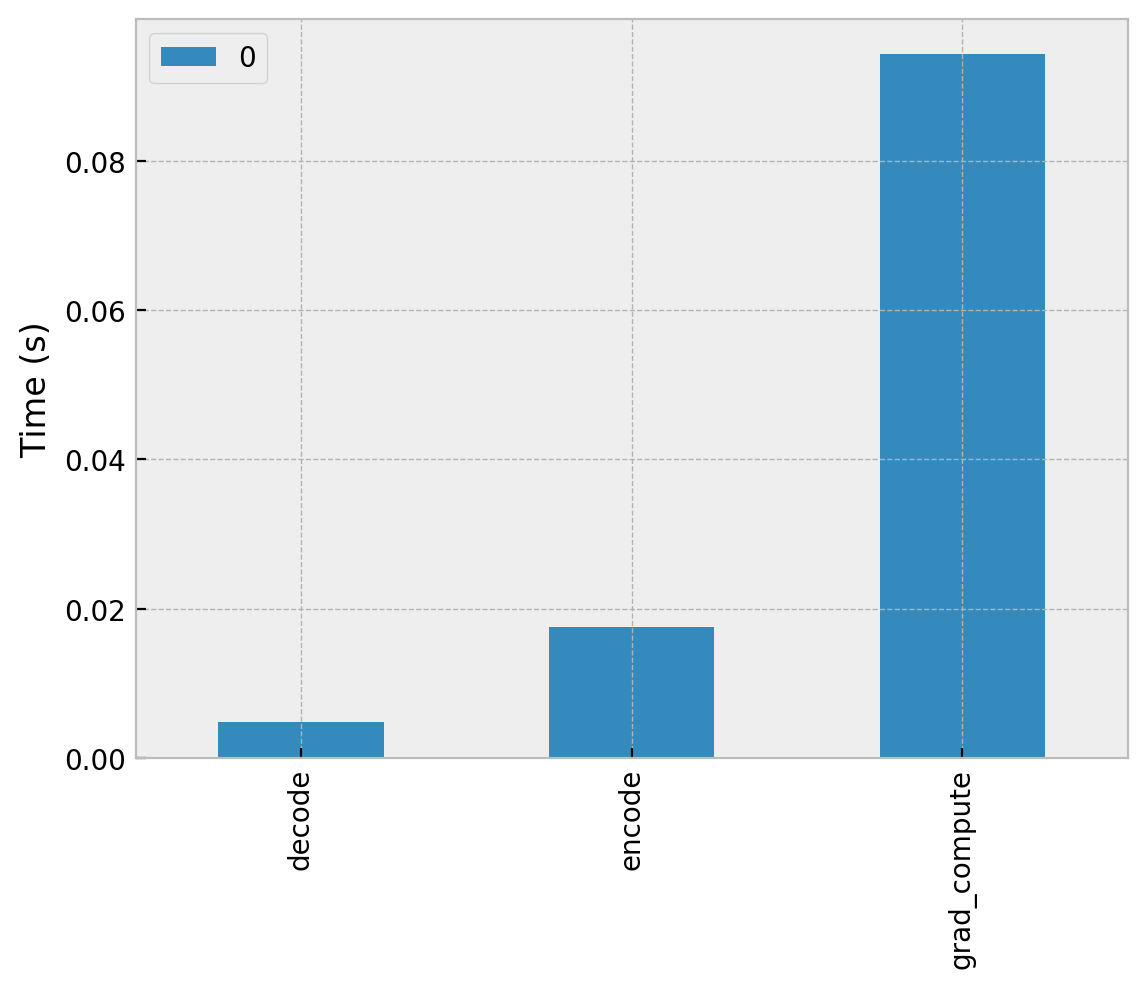

In [149]:
plt.style.use('bmh')
show.T.plot.bar(logy=False)
plt.ylabel('Time (s)')
# plt.grid()

TypeError: unsupported operand type(s) for -: 'str' and 'float'

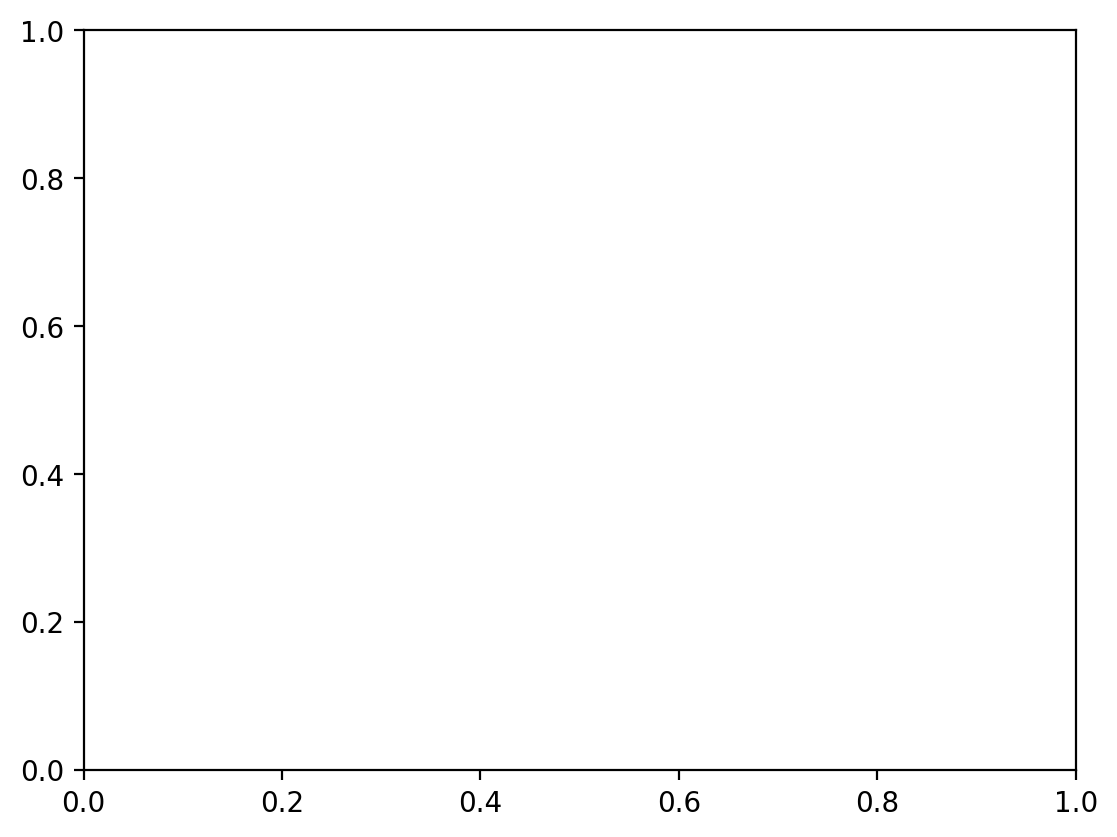

In [86]:
# plt.style.use('bmh')
plt.figure()
plt.bar?
plt.bar(['encode'], [df.encode_time.median()])
# plt.style.use('default')
# show.plot.bar(logy=False, y=['grad_compute_time', 'encode_time'])
# plt.ylabel('Time (s)')
# plt.grid()

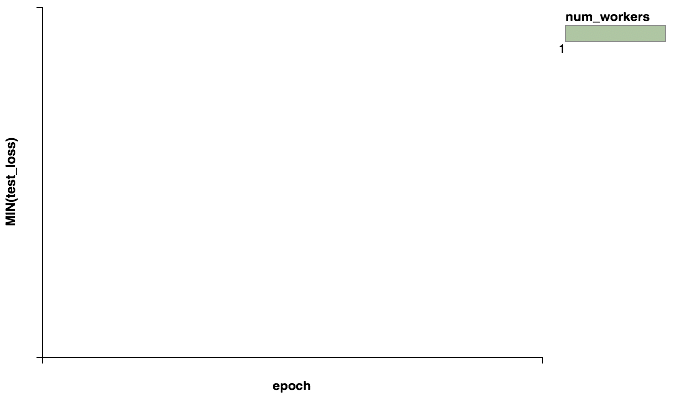

In [143]:
Chart(df).mark_line().encode(
    x=X('epoch', scale=Scale(type='linear')),
    y=Y('min(test_loss)'),#, scale=Scale(domain=(None, None), clamp=True)),
    color='num_workers')

In [8]:
# Chart(df).mark_line().encode(
#     x=X('epoch', scale=Scale(type='linear')),
#     y=Y('mean(test_acc)', scale=Scale(domain=(0.00, 1), clamp=True)),
#     color='num_workers')

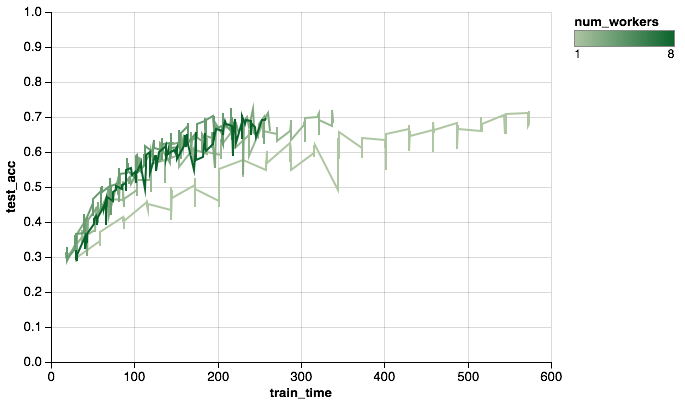

In [9]:
Chart(df).mark_line().encode(
    x=X('train_time', scale=Scale(type='linear', zero=False)),
    y=Y('test_acc', scale=Scale(domain=(0.00, 1), clamp=True)),
    color='num_workers')

In [13]:
def time_to_accuracy(df, accuracy, key='test_acc', time='train_time'):
    df = df[df[key] >= accuracy]
    if len(df) == 0:
        return {k: None for k in [key, time]}
    i = np.argmin(np.abs(df[key] - accuracy))
    return {k: df.T[i][k] for k in [key, time]}

times = []
accuracy = 0.650
# accuracy = 0.85
for one_df in dfs:
    summary = {}
    for key in ['seed', 'num_workers']:
        assert len(one_df[key].unique()) == 1
        summary[key] = one_df[key].unique()[0]
        
    times += [{**time_to_accuracy(one_df, accuracy, key='test_loss'),
               **summary}]


times = pd.DataFrame(times)
# times.head()
show = times.pivot_table(index='num_workers', values='train_time')
show['num_workers'] = show.index
show['speedup'] = show.T[1]['train_time'] / show['train_time']
show

,train_time,num_workers,speedup
num_workers,,,
1,539.928521,1,1.000000
2,332.459090,2,1.624045
3,230.388360,3,2.343558
4,211.018478,4,2.558679
8,230.909156,8,2.338272


In [14]:
# times['speedup'] = times[times.num_workers == 1]['time'].values[0] / times['time'] 
# from altair import X, Y, Scale
# Chart(times).mark_circle().encode(
#     x=X('train_time', scale=Scale(zero=False)),
#     y=Y('test_acc'   , scale=Scale(zero=False)),
#     color='num_workers', shape='seed')

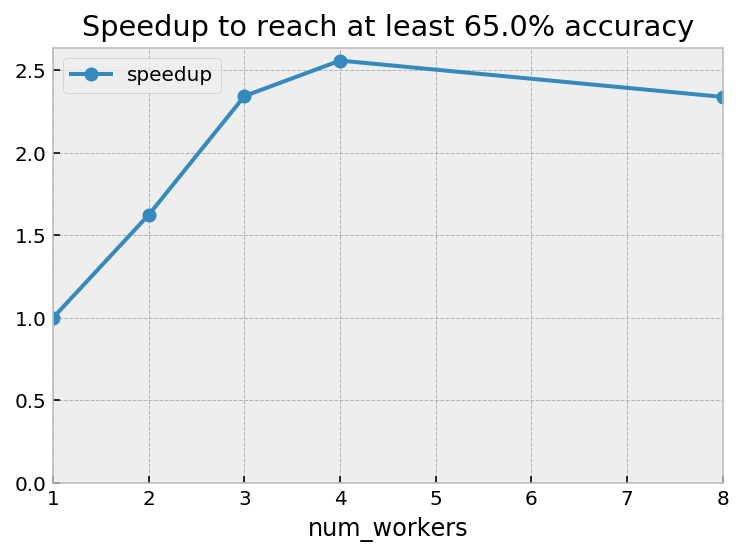

In [15]:
%config InlineBackend.figure_format = 'retina'
plt.style.use('bmh')
show.plot(x='num_workers', y='speedup', title=f'Speedup to reach at least {100*accuracy}% accuracy',
          style='o-', ylim=(0, None))
# plt.ylim(0, 1.2)
plt.show()